<a href="https://colab.research.google.com/github/trishla18/Satellite-imagery-using-U-Net/blob/main/Satellite_Imagery_using_U_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Satellite Imagery Data Preparation



In [1]:
!pip install patchify

In [2]:
import os
import cv2
from PIL import Image
import numpy as np
from patchify import patchify
from sklearn.preprocessing import MinMaxScaler, StandardScaler

from matplotlib import pyplot as plt
import random

In [3]:
minmaxscaler = MinMaxScaler()

In [4]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!ls-lah '/content/drive/MyDrive/Colab Notebooks/Dubai dataset/dubai_dataset/Semantic segmentation dataset'

/bin/bash: line 1: ls-lah: command not found


In [5]:
dataset_root_folder = '/content/drive/MyDrive/Colab Notebooks/Dubai dataset/dubai_dataset'

In [6]:
dataset_name = "Semantic segmentation dataset"

In [7]:
image_patch_size = 256

In [8]:
image_dataset = []
mask_dataset = []

for image_type in ['images' , 'masks']:
  if image_type == 'images':
    image_extension = 'jpg'
  elif image_type == 'masks':
     image_extension = 'png'
  for tile_id in range(1,8):
    for image_id in range(1,20):
      image = cv2.imread(f'{dataset_root_folder}/{dataset_name}/Tile {tile_id}/{image_type}/image_part_00{image_id}.{image_extension}',1)
      if image is not None:
        if image_type == 'masks':
          image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(image.shape)
        size_x = (image.shape[1]//image_patch_size)*image_patch_size
        size_y = (image.shape[0]//image_patch_size)*image_patch_size
        #print("{} --- {} - {}".format(image.shape, size_x, size_y))
        image = Image.fromarray(image)
        image = image.crop((0,0, size_x, size_y))
        #print("({},  {})".format(image.size[0],image.size[1]))
        image = np.array(image)
        patched_images = patchify(image, (image_patch_size, image_patch_size, 3), step=image_patch_size)
        #print(len(patched_images))
        for i in range(patched_images.shape[0]):
          for j in range(patched_images.shape[1]):
            if image_type == 'images':
              individual_patched_image = patched_images[i,j,:,:]
              #print(individual_patched_image.shape)
              individual_patched_image = minmaxscaler.fit_transform(individual_patched_image.reshape(-1, individual_patched_image.shape[-1])).reshape(individual_patched_image.shape)
              individual_patched_image = individual_patched_image[0]
              #print(individual_patched_image.shape)
              image_dataset.append(individual_patched_image)
            elif image_type == 'masks':
              individual_patched_mask = patched_images[i,j,:,:]
              individual_patched_mask = individual_patched_mask[0]
              mask_dataset.append(individual_patched_mask)


In [9]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)

In [10]:
print(len(image_dataset))
print(len(mask_dataset))

945
945


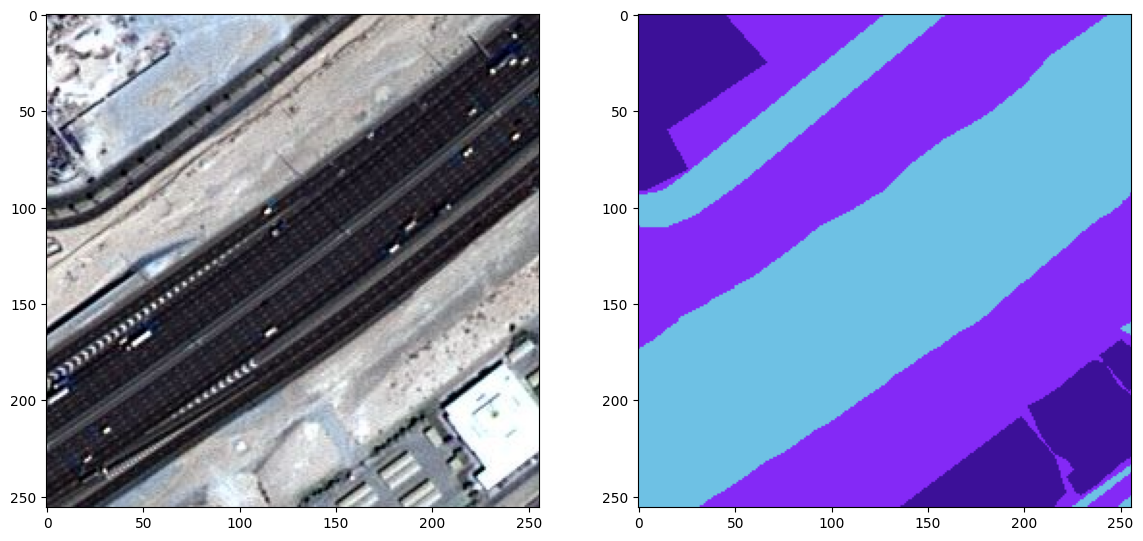

In [11]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])

In [12]:
class_building = '#3C1098'
class_building = class_building.lstrip('#')
class_building = np.array(tuple(int(class_building[i:i+2], 16) for i in (0,2,4)))
print(class_building)

class_land = '#8429F6'
class_land = class_land.lstrip('#')
class_land = np.array(tuple(int(class_land[i:i+2], 16) for i in (0,2,4)))
print(class_land)

class_road = '#6EC1E4'
class_road = class_road.lstrip('#')
class_road = np.array(tuple(int(class_road[i:i+2], 16) for i in (0,2,4)))
print(class_road)

class_vegetation = '#FEDD3A'
class_vegetation = class_vegetation.lstrip('#')
class_vegetation = np.array(tuple(int(class_vegetation[i:i+2], 16) for i in (0,2,4)))
print(class_vegetation)

class_water = '#E2A929'
class_water = class_water.lstrip('#')
class_water = np.array(tuple(int(class_water[i:i+2], 16) for i in (0,2,4)))
print(class_water)

class_unlabeled = '#9B9B9B'
class_unlabeled = class_unlabeled.lstrip('#')
class_unlabeled = np.array(tuple(int(class_unlabeled[i:i+2], 16) for i in (0,2,4)))
print(class_unlabeled)

[ 60  16 152]
[132  41 246]
[110 193 228]
[254 221  58]
[226 169  41]
[155 155 155]


In [13]:
label = individual_patched_mask

In [14]:
def rgb_to_label(label):
  label_segment = np.zeros(label.shape, dtype=np.uint8)
  label_segment[np.all(label == class_water, axis=-1)] = 0
  label_segment[np.all(label == class_land, axis=-1)] = 1
  label_segment[np.all(label == class_road, axis=-1)] = 2
  label_segment[np.all(label == class_building, axis=-1)] = 3
  label_segment[np.all(label == class_vegetation, axis=-1)] = 4
  label_segment[np.all(label == class_unlabeled, axis=-1)] = 5
  #print(label_segment)
  label_segment = label_segment[:,:,0]
  #print(label_segment)
  return label_segment

In [15]:
labels = []
for i in range(mask_dataset.shape[0]):
  label = rgb_to_label(mask_dataset[i])
  labels.append(label)

In [16]:
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)

In [17]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5], dtype=uint8)

In [18]:
print("Total unique labels based on masks: ",format(np.unique(labels)))

Total unique labels based on masks:  [0 1 2 3 4 5]


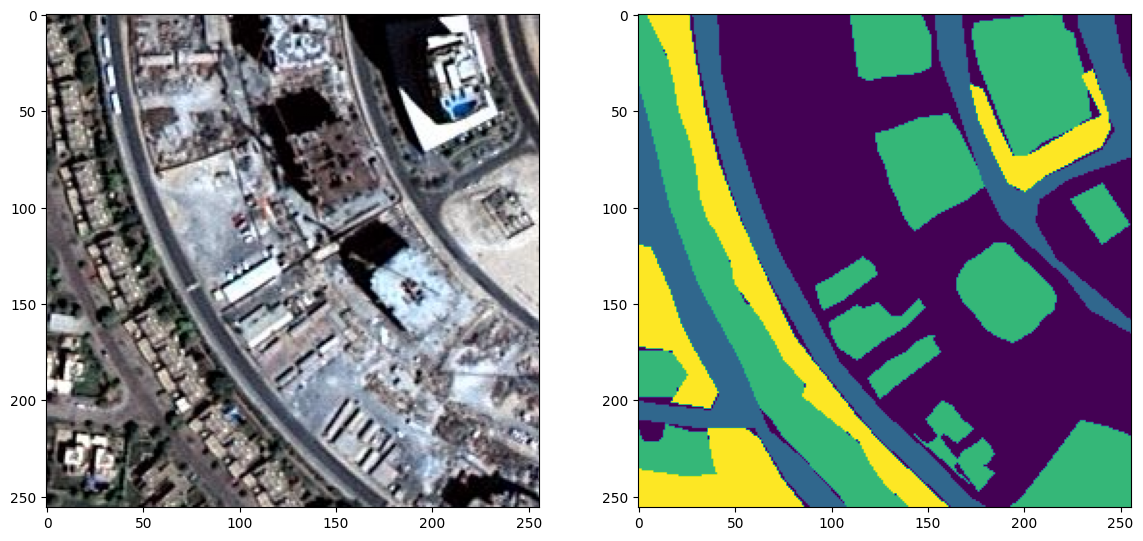

In [19]:
random_image_id = random.randint(0, len(image_dataset))

plt.figure(figsize=(14,8))
plt.subplot(121)
plt.imshow(image_dataset[random_image_id])
plt.subplot(122)
plt.imshow(mask_dataset[random_image_id])
plt.imshow(labels[random_image_id][:,:,0])

In [20]:
total_classes = len(np.unique(labels))

In [21]:
total_classes

6

In [22]:
from tensorflow.keras.utils import to_categorical

In [23]:
labels_categorical_dataset = to_categorical(labels, num_classes=total_classes)

In [24]:
master_trianing_dataset = image_dataset

In [25]:
from sklearn.model_selection import train_test_split

In [26]:
X_train, X_test, y_train, y_test = train_test_split(master_trianing_dataset, labels_categorical_dataset, test_size=0.15, random_state=100)

In [27]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(803, 256, 256, 3)
(142, 256, 256, 3)
(803, 256, 256, 6)
(142, 256, 256, 6)


In [28]:
image_height = X_train.shape[1]
image_width = X_train.shape[2]
image_channels = X_train.shape[3]
total_classes = y_train.shape[3]

In [29]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


# Deep Learning with Satellite Imagery Data

In [30]:
!pip install -U segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 5.2 MB/s eta 0:00:00


In [31]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda

In [32]:
from keras import backend as K

In [33]:
def jaccard_coef(y_true, y_pred):
  y_true_flatten = K.flatten(y_true)
  y_pred_flatten = K.flatten(y_pred)
  intersection = K.sum(y_true_flatten * y_pred_flatten)
  final_coef_value = (intersection + 1.0) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) - intersection + 1.0)
  return final_coef_value


In [34]:

def multi_unet_model(n_classes=5, image_height=256, image_width=256, image_channels=1):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="softmax")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [35]:
metrics = ["accuracy", jaccard_coef]

In [36]:
print(image_height)
print(image_width)
print(image_channels)
print(total_classes)

256
256
3
6


In [37]:
def get_deep_learning_model():
  return multi_unet_model(n_classes=total_classes,
                          image_height=image_height,
                          image_width=image_width,
                          image_channels=image_channels)

In [38]:
model = get_deep_learning_model()

In [39]:
# Please uncomment this line to get model confiuration
# model.get_config()

## Generating Loss Function

- dice loss > Focal Loss > Total Loss
- Total Loss = (Dice loss + (1*Focal Loss))

In [40]:
weights = [0.1666, 0.1666, 0.1666, 0.1666, 0.1666, 0.1666]

In [41]:
!pip install segmentation-models

In [42]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from tensorflow import keras
import segmentation_models as sm

Segmentation Models: using `tf.keras` framework.


In [43]:
dice_loss = sm.losses.DiceLoss(class_weights = weights)

In [44]:
focal_loss = sm.losses.CategoricalFocalLoss()

In [45]:
total_loss = dice_loss + (1 * focal_loss)

## Model compilation

In [46]:
import tensorflow as tf

In [47]:
tf.keras.backend.clear_session()


In [48]:
model.compile(optimizer="adam", loss=total_loss, metrics=metrics)

In [49]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         448       ['input_1[0][0]']             
                                                                                                  
 dropout (Dropout)           (None, 256, 256, 16)         0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['dropout[0][0]']             
                                                                                              

In [50]:
model_history = model.fit(X_train, y_train,
                          batch_size=16,
                          verbose=1,
                          epochs=90,
                          validation_data=(X_test, y_test),
                          shuffle=False)

Epoch 1/90
51/51 [==============================] - 50s 401ms/step - loss: 1.0037 - accuracy: 0.5581 - jaccard_coef: 0.2510 - val_loss: 0.9935 - val_accuracy: 0.6580 - val_jaccard_coef: 0.2613
Epoch 2/90
51/51 [==============================] - 10s 201ms/step - loss: 0.9791 - accuracy: 0.6851 - jaccard_coef: 0.3903 - val_loss: 0.9740 - val_accuracy: 0.6905 - val_jaccard_coef: 0.3451
Epoch 3/90
51/51 [==============================] - 10s 201ms/step - loss: 0.9667 - accuracy: 0.7085 - jaccard_coef: 0.4300 - val_loss: 0.9952 - val_accuracy: 0.6379 - val_jaccard_coef: 0.4116
Epoch 4/90
51/51 [==============================] - 10s 205ms/step - loss: 0.9581 - accuracy: 0.7304 - jaccard_coef: 0.4770 - val_loss: 0.9936 - val_accuracy: 0.6174 - val_jaccard_coef: 0.3840
Epoch 5/90
51/51 [==============================] - 10s 203ms/step - loss: 0.9517 - accuracy: 0.7472 - jaccard_coef: 0.5083 - val_loss: 0.9734 - val_accuracy: 0.6681 - val_jaccard_coef: 0.4415
Epoch 6/90
51/51 [=================

In [51]:
history_a = model_history

In [52]:
history_a.history

{'loss': [1.0037288665771484,
  0.9790582656860352,
  0.9667026400566101,
  0.9580798149108887,
  0.9516921639442444,
  0.9471839070320129,
  0.9427822232246399,
  0.9397239685058594,
  0.9370443224906921,
  0.9341863989830017,
  0.9319732189178467,
  0.9302688241004944,
  0.9276430010795593,
  0.9269217848777771,
  0.9233892560005188,
  0.9225136041641235,
  0.9200879335403442,
  0.9195573329925537,
  0.9194308519363403,
  0.9181175827980042,
  0.9162609577178955,
  0.9160671830177307,
  0.9143814444541931,
  0.9161056280136108,
  0.9135460257530212,
  0.9120500087738037,
  0.912170946598053,
  0.911314070224762,
  0.9100841879844666,
  0.9098372459411621,
  0.9086582660675049,
  0.907227635383606,
  0.9093188047409058,
  0.9123212099075317,
  0.9071686267852783,
  0.9056769609451294,
  0.904262125492096,
  0.9039704203605652,
  0.9120289087295532,
  0.9068396091461182,
  0.9048481583595276,
  0.9042433500289917,
  0.9030339121818542,
  0.9006381034851074,
  0.9003072381019592,
  0.89

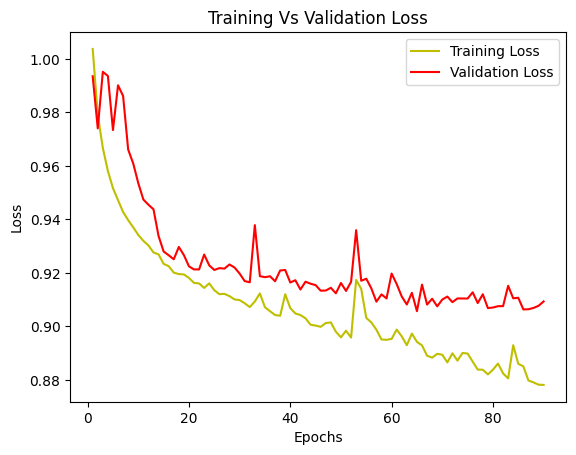

In [53]:
loss = history_a.history['loss']
val_loss = history_a.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Training Vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

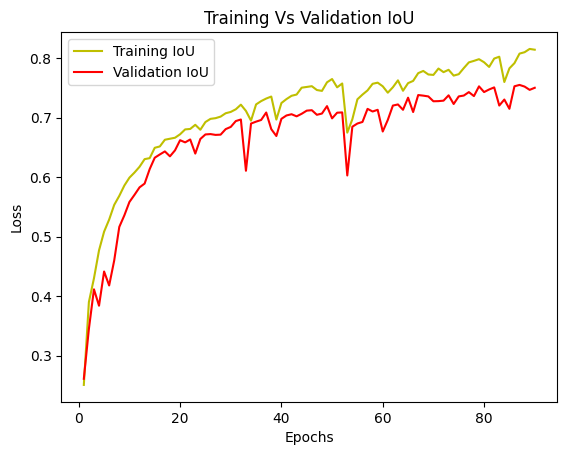

In [54]:
jaccard_coef = history_a.history['jaccard_coef']
val_jaccard_coef = history_a.history['val_jaccard_coef']

epochs = range(1, len(jaccard_coef) + 1)
plt.plot(epochs, jaccard_coef, 'y', label="Training IoU")
plt.plot(epochs, val_jaccard_coef, 'r', label="Validation IoU")
plt.title("Training Vs Validation IoU")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()



In [55]:
model_history.params

{'verbose': 1, 'epochs': 90, 'steps': 51}

In [56]:
y_pred = model.predict(X_test)

5/5 [==============================] - 5s 56ms/step


In [57]:
len(y_pred)

142

In [58]:
y_pred

array([[[[2.40536798e-02, 7.02290893e-01, 7.79846907e-02,
          4.96933237e-02, 1.45110101e-01, 8.67342926e-04],
         [7.25700939e-03, 8.39368701e-01, 3.85925509e-02,
          2.89258845e-02, 8.57344791e-02, 1.21328027e-04],
         [8.08436051e-03, 7.89984763e-01, 3.49579677e-02,
          2.89539620e-02, 1.37943104e-01, 7.58686219e-05],
         ...,
         [1.62553899e-02, 7.33554304e-01, 4.91538011e-02,
          3.68682444e-02, 1.63946062e-01, 2.22096554e-04],
         [2.30517052e-02, 5.76253235e-01, 7.58801475e-02,
          3.55471857e-02, 2.88889885e-01, 3.77876218e-04],
         [3.00923940e-02, 2.37321004e-01, 1.54104874e-01,
          2.85913777e-02, 5.47958434e-01, 1.93194684e-03]],

        [[8.10901821e-03, 7.95471728e-01, 4.46600094e-02,
          2.87073702e-02, 1.22932188e-01, 1.19730306e-04],
         [1.64693908e-03, 8.33731711e-01, 2.47789994e-02,
          1.42701194e-02, 1.25567168e-01, 5.09447500e-06],
         [1.71394751e-03, 7.58595407e-01, 2.1166

In [59]:
y_pred_argmax = np.argmax(y_pred, axis=3)

In [60]:
len(y_pred_argmax)

142

In [61]:
y_pred_argmax

array([[[1, 1, 1, ..., 1, 1, 4],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 3, 3, 1],
        [2, 2, 2, ..., 3, 3, 1],
        [2, 2, 2, ..., 3, 3, 3],
        ...,
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2],
        [1, 1, 1, ..., 2, 2, 2]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 0, 1, 1],
        [1, 1, 1, ..., 0, 0, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [62]:
y_test_argmax = np.argmax(y_test, axis=3)

In [63]:
y_test_argmax

array([[[3, 3, 3, ..., 1, 1, 1],
        [3, 3, 3, ..., 3, 3, 3],
        [3, 3, 3, ..., 3, 3, 3],
        ...,
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1],
        [0, 0, 0, ..., 1, 1, 1]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        [2, 2, 2, ..., 1, 1, 1],
        ...,
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 2, ..., 0, 0, 0],
        [2, 2, 1, ..., 0, 0, 0]],

       ...,

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

## Comparing prediction results
-  using test images using mask images and predicted result images..

In [64]:
import random


In [65]:
test_image_number = random.randint(0, len(X_test))

test_image = X_test[test_image_number]
ground_truth_image = y_test_argmax[test_image_number]

test_image_input = np.expand_dims(test_image, 0)

prediction = model.predict(test_image_input)
predicted_image = np.argmax(prediction, axis=3)
predicted_image = predicted_image[0,:,:]

1/1 [==============================] - 2s 2s/step


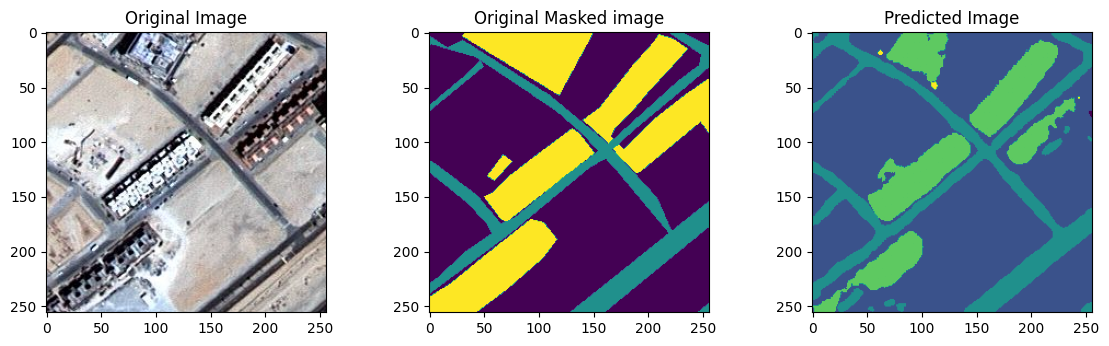

In [66]:
plt.figure(figsize=(14,8))
plt.subplot(231)
plt.title("Original Image")
plt.imshow(test_image)
plt.subplot(232)
plt.title("Original Masked image")
plt.imshow(ground_truth_image)
plt.subplot(233)
plt.title("Predicted Image")
plt.imshow(predicted_image)


In [67]:
model.save("satellite_segmentation_full.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
!ls -lah

total 23M
drwxr-xr-x 1 root root 4.0K Jul  3 15:34 .
drwxr-xr-x 1 root root 4.0K Jul  3 15:10 ..
drwxr-xr-x 4 root root 4.0K Jul  1 13:21 .config
drwx------ 5 root root 4.0K Jul  3 15:13 drive
drwxr-xr-x 1 root root 4.0K Jul  1 13:21 sample_data
-rw-r--r-- 1 root root  23M Jul  3 15:34 satellite_segmentation_full.h5
